In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q tensorflow matplotlib numpy scikit-learn seaborn

import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import time

# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


  
2. Data Understanding and Preparation
Dataset Description:  
- Traffic_Sign_-2 dataset containing 43 classes of road signs
- Approximately 39,000 training images and 12,600 test images
- Images vary in lighting/angle but are centered on signs
- Split: 80% training (with 20% of that for validation), 20% testing

Checking training images...
Removed 35 corrupted images
Found 12853 images belonging to 5 classes.
Found 3212 images belonging to 5 classes.
Class names: ['Cautions', 'Crossings', 'DIrection', 'No Entry', 'SpeedLimit']


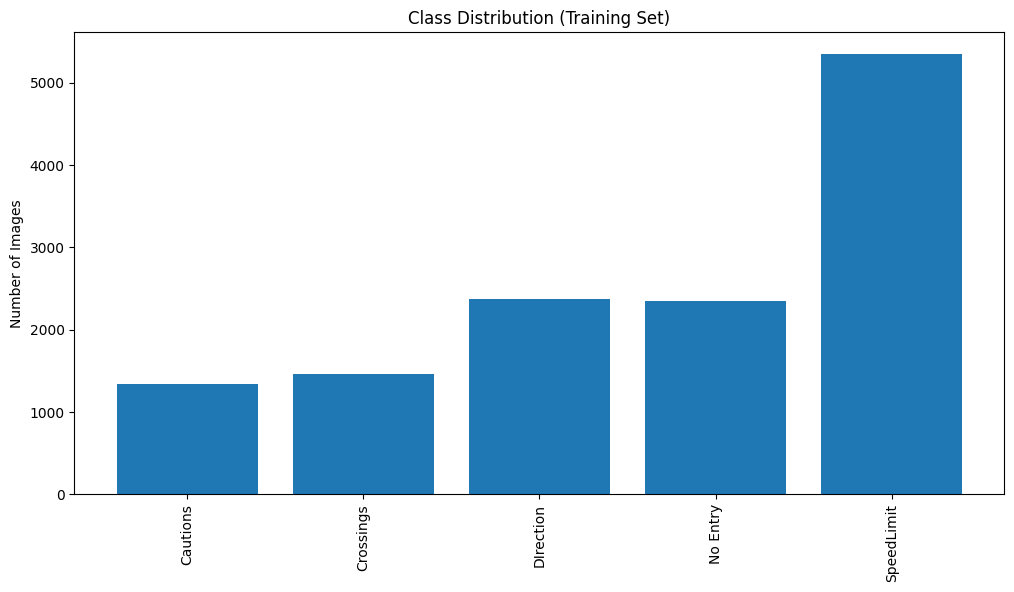

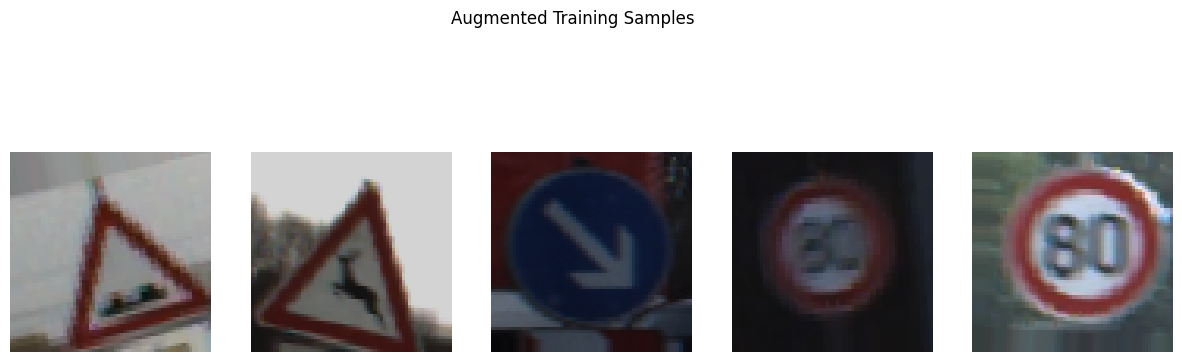

In [2]:
# Set paths
data_dir = '/content/drive/MyDrive/AI/Traffic_Sign_-2'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

# Verify images
def verify_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()
                img.close()
            except (IOError, SyntaxError):
                corrupted.append(file_path)
                os.remove(file_path)
    return corrupted

print("Checking training images...")
corrupted_train = verify_images(train_dir)
print(f"Removed {len(corrupted_train)} corrupted images")

# Image parameters
img_size = 64  # Chosen for balance between detail and computational efficiency
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,      # Signs may appear at slight angles
    width_shift_range=0.1,  # Small horizontal shifts
    height_shift_range=0.1,
    shear_range=0.1,        # Perspective variations
    zoom_range=0.1,
    brightness_range=[0.7,1.3],  # Lighting variations
    horizontal_flip=False,  # Signs shouldn't be flipped
    validation_split=0.2    # 20% validation split (common for medium-sized datasets)
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print("Class names:", class_names)

# ### Data Visualization
# Class distribution
class_counts = np.bincount(train_generator.classes)
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.title("Class Distribution (Training Set)")
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.show()

# Sample augmented images
aug_images, _ = next(train_generator)
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(aug_images[i])
    plt.axis('off')
plt.suptitle("Augmented Training Samples")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,693 (4.98 MB)

 Trainable params: 1,306,693 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 95s 221ms/step - accuracy: 0.6991 - loss: 0.7672 - val_accuracy: 0.8253 - val_loss: 0.5127
Epoch 2/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.9502 - loss: 0.1235 - val_accuracy: 0.8748 - val_loss: 0.5150
Epoch 3/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 171ms/step - accuracy: 0.9785 - loss: 0.0651 - val_accuracy: 0.8811 - val_loss: 0.3972
Epoch 4/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 171ms/step - accuracy: 0.9853 - loss: 0.0437 - val_accuracy: 0.8854 - val_loss: 1.1547
Epoch 5/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 90s 190ms/step - accuracy: 0.9911 - loss: 0.0283 - val_accuracy: 0.8742 - val_loss: 1.3729
Epoch 6/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 77s 176ms/step - accuracy: 0.9909 - loss: 0.0314 - val_accuracy: 0.8798 - val_loss: 0.9993
Epoch 7/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 68s 170ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.8801 - val_loss: 0.8405
Epoch 8/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 69s 172ms/step - accuracy: 0.9922 - loss: 0

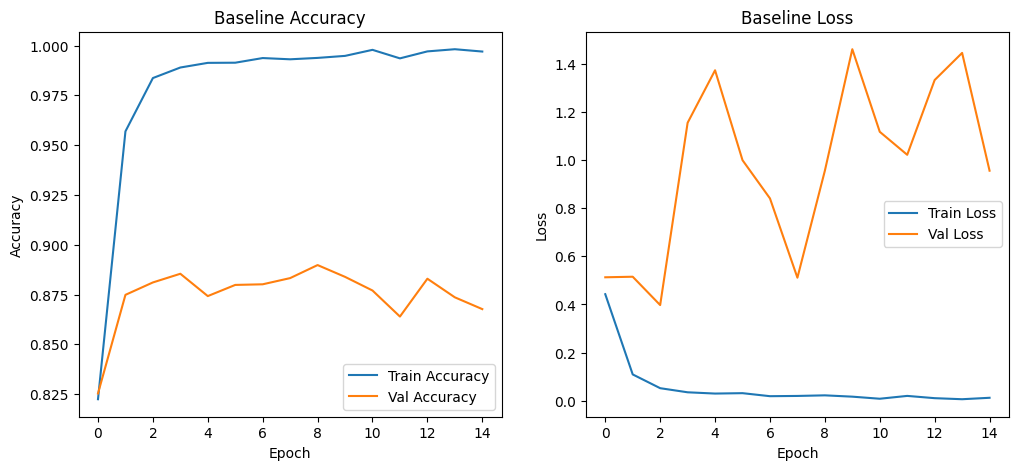

In [3]:
# ## 3. Baseline CNN Model
def build_baseline_model():
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Classifier
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_model = build_baseline_model()
baseline_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
baseline_model.summary()

# Train baseline
start_time = time.time()
baseline_history = baseline_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)
baseline_time = time.time() - start_time

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Baseline Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['loss'], label='Train Loss')
plt.plot(baseline_history.history['val_loss'], label='Val Loss')
plt.title('Baseline Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


 4. Deeper CNN with Regularization
Architecture Changes:
 - Doubled convolutional layers (6 blocks)
 - Added Batch Normalization after each conv layer
 - Added Dropout for regularization
 - Increased filter sizes progressively


=== Training Deeper Model with SGD ===


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,619,301 (17.62 MB)

 Trainable params: 4,616,869 (17.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

Epoch 1/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 91s 200ms/step - accuracy: 0.6426 - loss: 0.9983 - val_accuracy: 0.7961 - val_loss: 0.4188
Epoch 2/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.8376 - loss: 0.3978 - val_accuracy: 0.8070 - val_loss: 0.4806
Epoch 3/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 73s 182ms/step - accuracy: 0.9290 - loss: 0.1851 - val_accuracy: 0.8752 - val_loss: 0.3269
Epoch 4/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 79s 197ms/step - accuracy: 0.9547 - loss: 0.1163 - val_accuracy: 0.8356 - val_loss: 0.5739
Epoch 5/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 71s 178ms/step - accuracy: 0.9721 - loss: 0.0741 - val_accuracy: 0.9013 - val_loss: 0.3009
Epoch 6/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 72s 179ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.8705 - val_loss: 0.6152
Epoch 7/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 77s 191ms/step - accuracy: 0.9838 - loss: 0.0489 - val_accuracy: 0.8667 - val_loss: 0.8150
Epoch 8/20
402/402 ━━━━━━━━━━━━━━━━━━━━ 71s 177ms/step - accuracy: 0.9900 - loss: 0

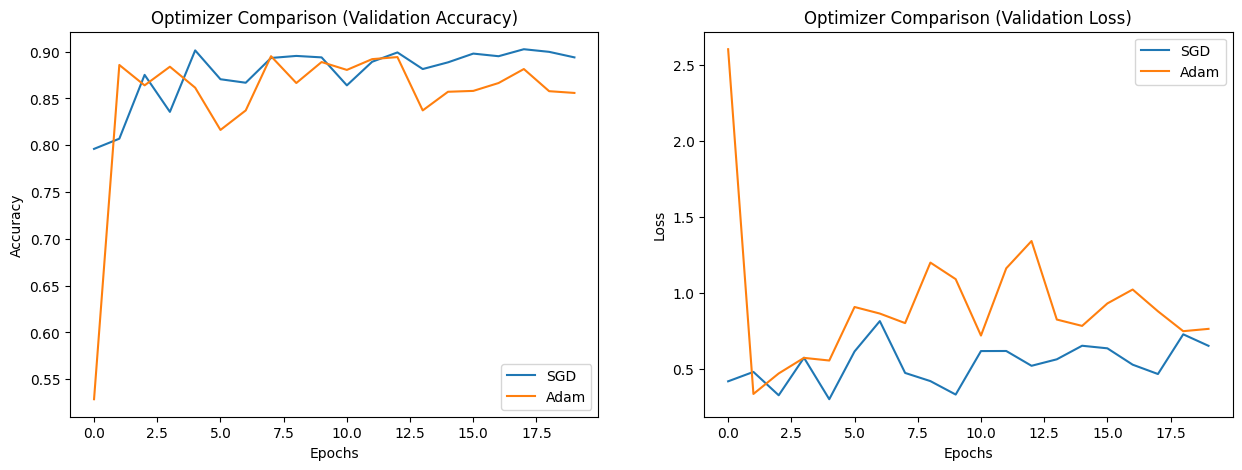

In [ ]:

def build_deeper_model():
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Classifier
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Train with SGD
print("\n=== Training Deeper Model with SGD ===")
sgd_model = build_deeper_model()
sgd_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
sgd_model.summary()

start_time = time.time()
sgd_history = sgd_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)
sgd_time = time.time() - start_time

# Train with Adam
print("\n=== Training Deeper Model with Adam ===")
adam_model = build_deeper_model()
adam_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

start_time = time.time()
adam_history = adam_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)
adam_time = time.time() - start_time

# Plot comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(sgd_history.history['val_accuracy'], label='SGD')
plt.plot(adam_history.history['val_accuracy'], label='Adam')
plt.title('Optimizer Comparison (Validation Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sgd_history.history['val_loss'], label='SGD')
plt.plot(adam_history.history['val_loss'], label='Adam')
plt.title('Optimizer Comparison (Validation Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


5. Transfer Learning with MobileNetV2
Rationale for MobileNetV2:
 - Lightweight architecture suitable for traffic signs
 - Pre-trained on ImageNet (contains similar shapes/colors)
 - Good trade-off between accuracy and computational cost

In [ ]:

# Data generators for MobileNet (224x224 input)
transfer_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

transfer_train = transfer_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

transfer_val = transfer_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Build model
base_model = applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
base_model.trainable = False  # Freeze base model initially

transfer_model = models.Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

transfer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
transfer_model.summary()

# Initial training (feature extraction)
start_time = time.time()
transfer_history = transfer_model.fit(
    transfer_train,
    epochs=10,
    validation_data=transfer_val
)
transfer_time = time.time() - start_time

# Fine-tuning (unfreeze last 50 layers)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

start_time = time.time()
fine_tune_history = transfer_model.fit(
    transfer_train,
    epochs=5,
    validation_data=transfer_val
)
transfer_time += time.time() - start_time

Found 12853 images belonging to 5 classes.
Found 3212 images belonging to 5 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,229 (9.87 MB)

 Trainable params: 329,733 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Epoch 1/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 130s 299ms/step - accuracy: 0.8508 - loss: 0.4427 - val_accuracy: 0.8898 - val_loss: 0.3270
Epoch 2/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 62s 153ms/step - accuracy: 0.9548 - loss: 0.1202 - val_accuracy: 0.8960 - val_loss: 0.3242
Epoch 3/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 70s 175ms/step - accuracy: 0.9707 - loss: 0.0831 - val_accuracy: 0.9010 - val_loss: 0.3866
Epoch 4/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 63s 156ms/step - accuracy: 0.9787 - loss: 0.0625 - val_accuracy: 0.8994 - val_loss: 0.2926
Epoch 5/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 57s 141ms/step - accuracy: 0.9786 - loss: 0.0603 - val_accuracy: 0.8941 - val_loss: 0.3044
Epoch 6/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 60s 150ms/step - accuracy: 0.9801 - loss: 0.0535 - val_accuracy: 0.8951 - val_loss: 0.3999
Epoch 7/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 59s 148ms/step - accuracy: 0.9860 - loss: 0.0427 - val_accuracy: 0.8864 - val_loss: 0.3936
Epoch 8/10
402/402 ━━━━━━━━━━━━━━━━━━━━ 60s 150ms/step - accuracy: 0.9817 - loss: 

 6. Comparative Analysis


=== Baseline CNN Evaluation ===
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step
              precision    recall  f1-score   support

    Cautions     0.1019    0.0659    0.0800       334
   Crossings     0.1017    0.1346    0.1158       364
   DIrection     0.1768    0.1774    0.1771       592
    No Entry     0.1799    0.1860    0.1829       586
  SpeedLimit     0.4247    0.4177    0.4211      1336

    accuracy                         0.2625      3212
   macro avg     0.1970    0.1963    0.1954      3212
weighted avg     0.2641    0.2625    0.2626      3212



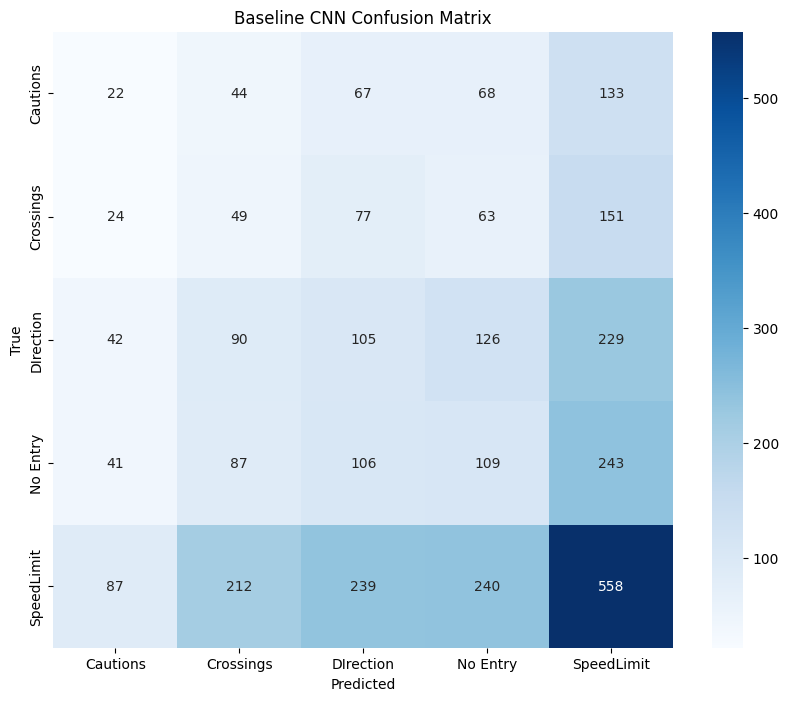


=== Deeper CNN (Adam) Evaluation ===
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step
              precision    recall  f1-score   support

    Cautions     0.1033    0.0659    0.0804       334
   Crossings     0.0969    0.1291    0.1107       364
   DIrection     0.1791    0.1791    0.1791       592
    No Entry     0.1990    0.1962    0.1976       586
  SpeedLimit     0.4226    0.4251    0.4239      1336

    accuracy                         0.2671      3212
   macro avg     0.2002    0.1991    0.1983      3212
weighted avg     0.2668    0.2671    0.2663      3212



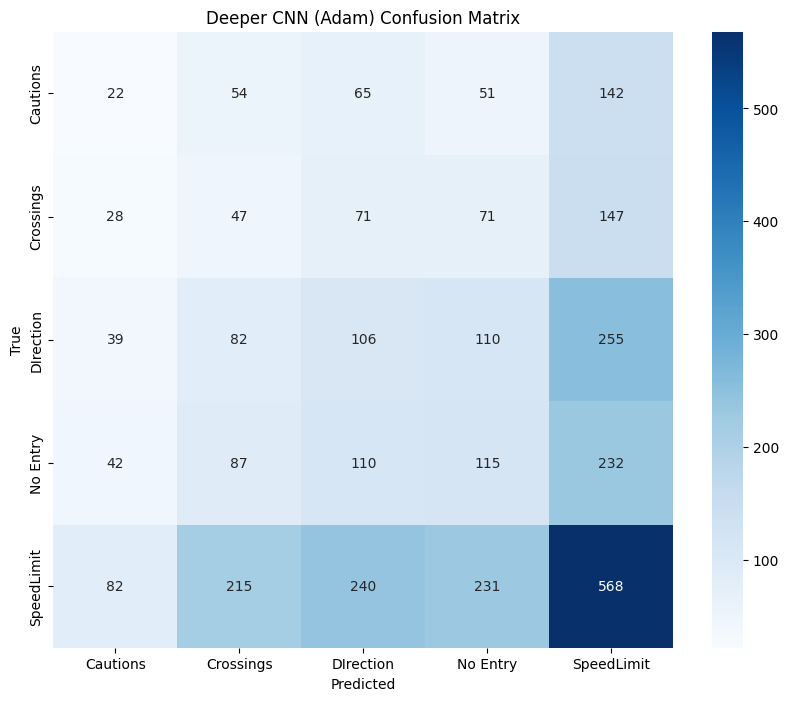


=== MobileNetV2 Evaluation ===
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step
              precision    recall  f1-score   support

    Cautions     0.0909    0.0509    0.0653       334
   Crossings     0.1133    0.1593    0.1324       364
   DIrection     0.1943    0.1943    0.1943       592
    No Entry     0.1737    0.1689    0.1713       586
  SpeedLimit     0.4264    0.4311    0.4287      1336

    accuracy                         0.2693      3212
   macro avg     0.1997    0.2009    0.1984      3212
weighted avg     0.2671    0.2693    0.2672      3212



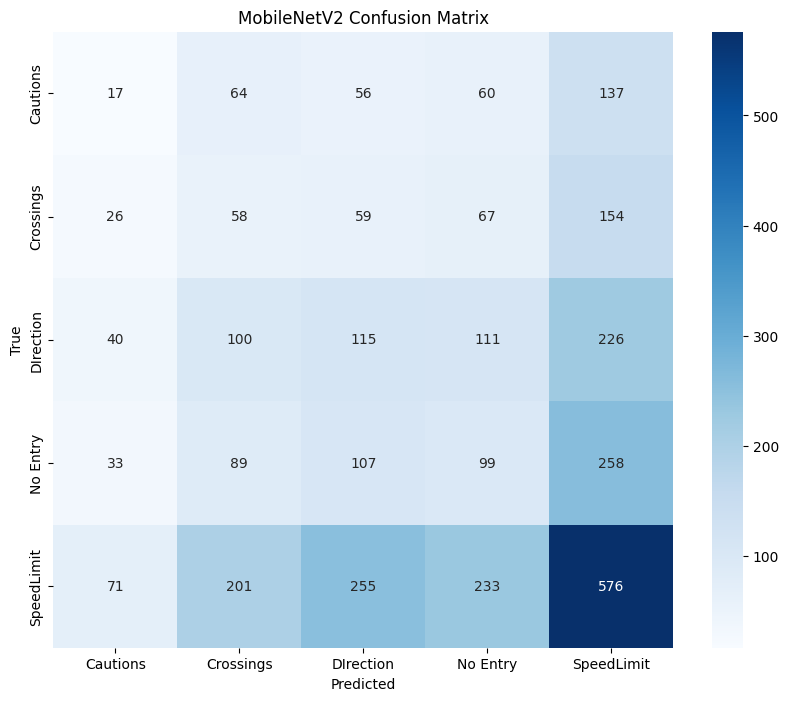


=== Model Performance Comparison ===
               Model  Val Accuracy  Training Time (min)  Parameters
0       Baseline CNN        0.8898              18.4000     1306693
1   Deeper CNN (SGD)        0.9026              24.7800     4619301
2  Deeper CNN (Adam)        0.8951              24.2500     4619301
3        MobileNetV2        0.9060              17.0700     2588229


In [ ]:

# Generate evaluation metrics
def generate_report(model, history, generator, model_name):
    print(f"\n=== {model_name} Evaluation ===")

    # Metrics
    y_pred = np.argmax(model.predict(generator), axis=1)
    y_true = generator.classes

    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_true, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate all models
generate_report(baseline_model, baseline_history, val_generator, "Baseline CNN")
generate_report(adam_model, adam_history, val_generator, "Deeper CNN (Adam)")
generate_report(transfer_model, transfer_history, transfer_val, "MobileNetV2")

# Performance comparison table
print("\n=== Model Performance Comparison ===")
comparison = {
    'Model': ['Baseline CNN', 'Deeper CNN (SGD)', 'Deeper CNN (Adam)', 'MobileNetV2'],
    'Val Accuracy': [
        max(baseline_history.history['val_accuracy']),
        max(sgd_history.history['val_accuracy']),
        max(adam_history.history['val_accuracy']),
        max(transfer_history.history['val_accuracy'])
    ],
    'Training Time (min)': [
        round(baseline_time/60, 2),
        round(sgd_time/60, 2),
        round(adam_time/60, 2),
        round(transfer_time/60, 2)
    ],
    'Parameters': [
        baseline_model.count_params(),
        sgd_model.count_params(),
        adam_model.count_params(),
        transfer_model.count_params()
    ]
}

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print(pd.DataFrame(comparison))



                    TESTING BASELINE CNN                    
 Loaded 10 valid test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


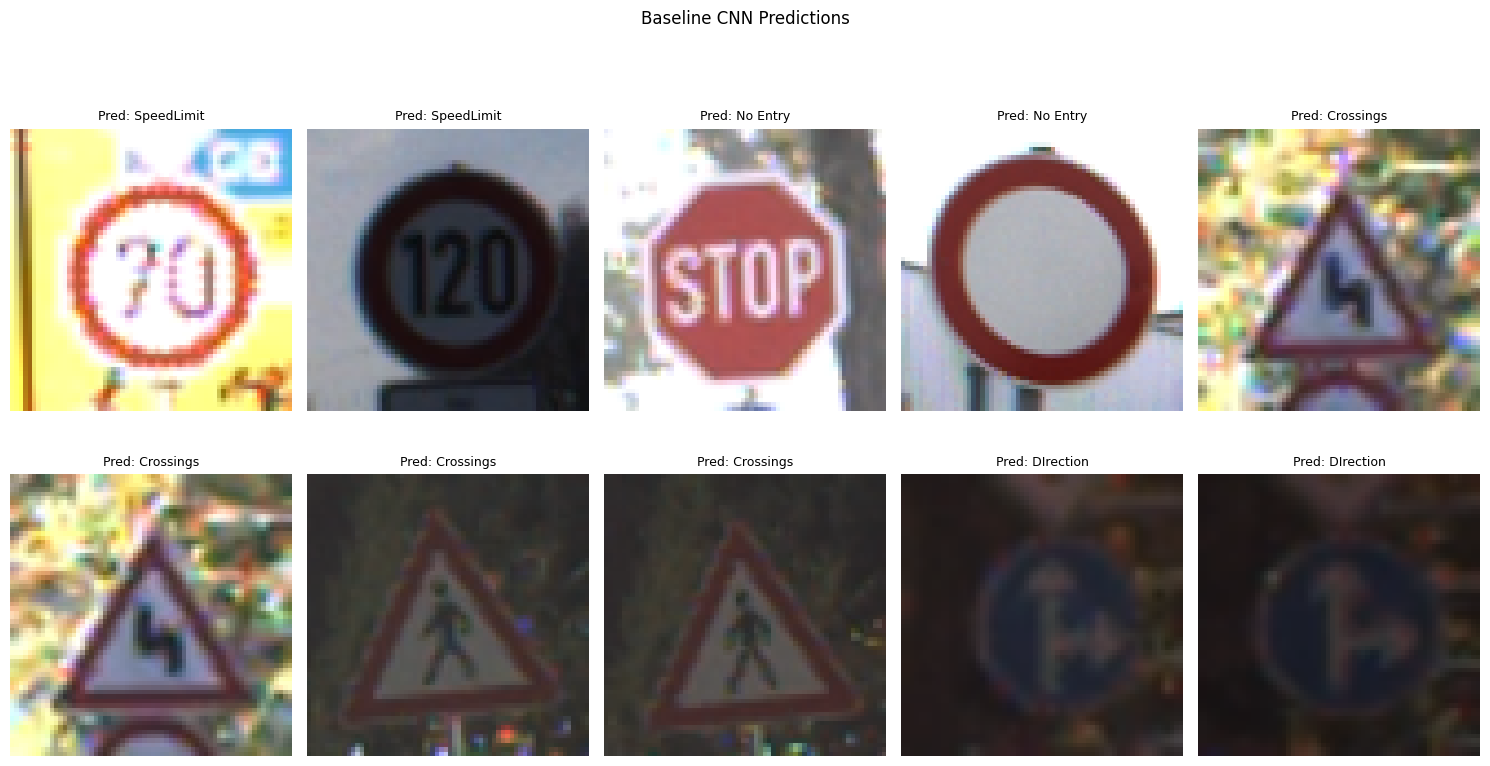


 Prediction Results:
00004_00002_00011.png     → SpeedLimit
00008_00013_00018.png     → SpeedLimit
00014_00000_00002.png     → No Entry
00015_00002_00026.png     → No Entry
00021_00000_00000.png     → Crossings
00021_00000_00001.png     → Crossings
00027_00000_00002.png     → Crossings
00027_00000_00003.png     → Crossings
00036_00000_00001.png     → DIrection
00036_00000_00002.png     → DIrection

                 TESTING DEEPER CNN (ADAM)                  
 Loaded 10 valid test images
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


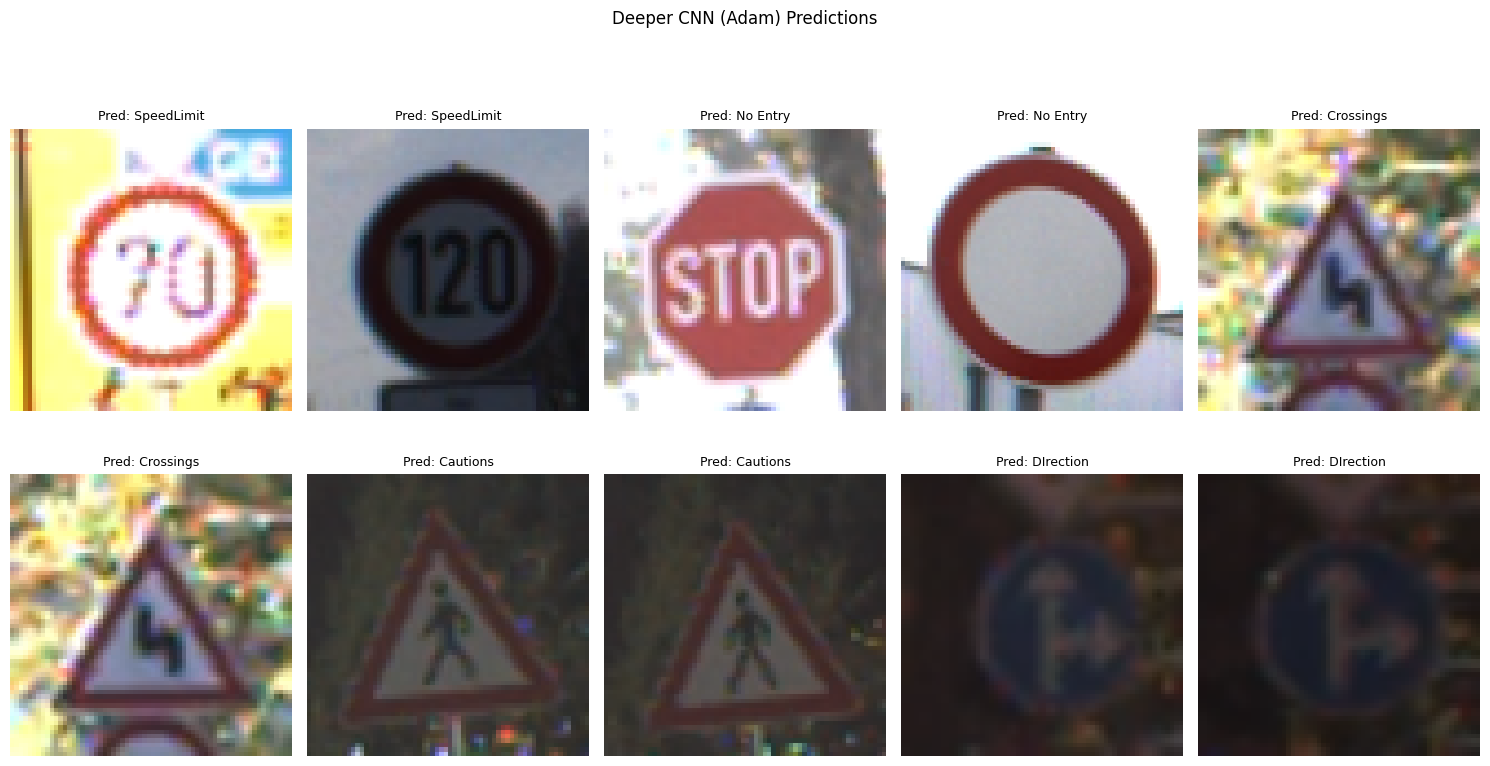


 Prediction Results:
00004_00002_00011.png     → SpeedLimit
00008_00013_00018.png     → SpeedLimit
00014_00000_00002.png     → No Entry
00015_00002_00026.png     → No Entry
00021_00000_00000.png     → Crossings
00021_00000_00001.png     → Crossings
00027_00000_00002.png     → Cautions
00027_00000_00003.png     → Cautions
00036_00000_00001.png     → DIrection
00036_00000_00002.png     → DIrection

                    TESTING MOBILENETV2                     
 Loaded 10 valid test images


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


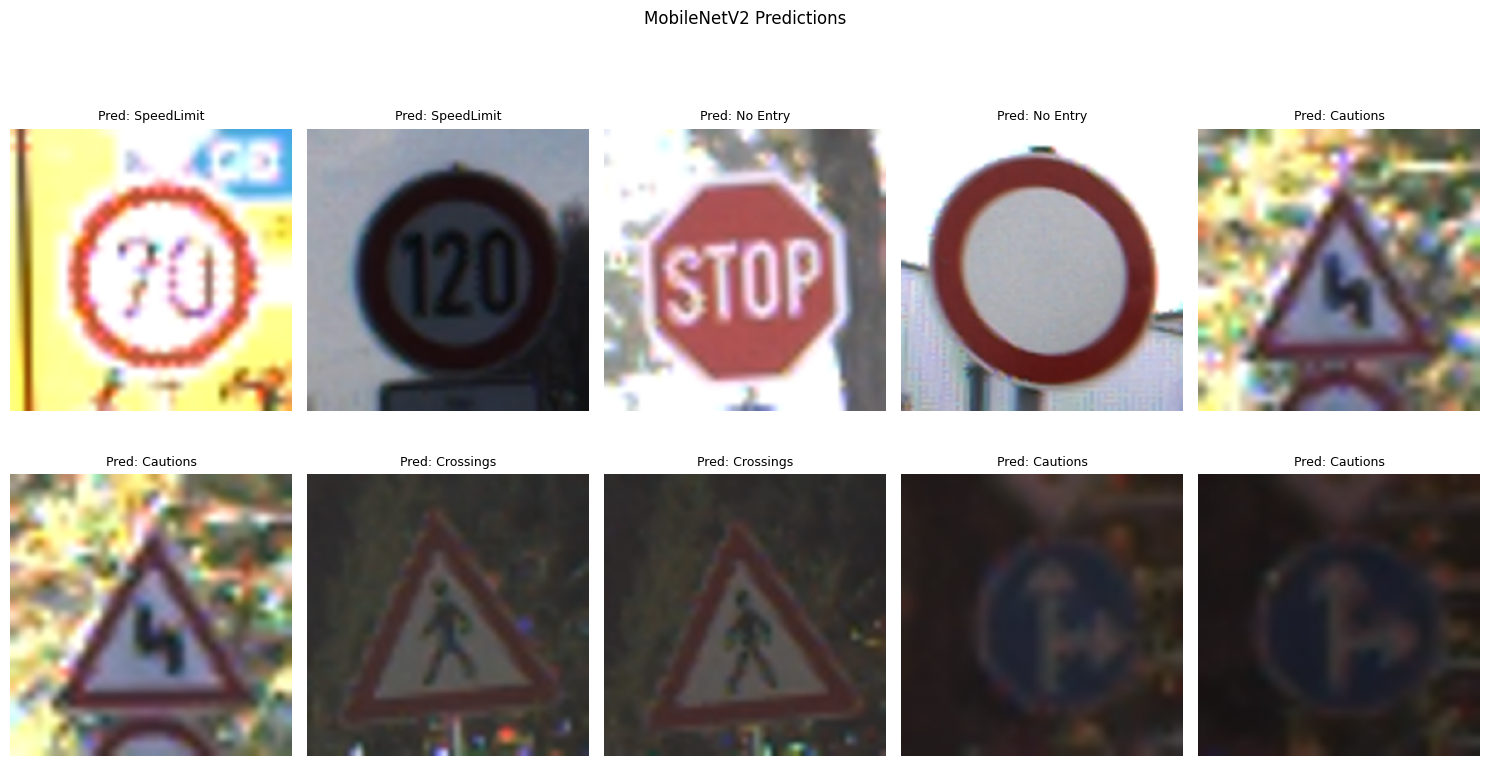


 Prediction Results:
00004_00002_00011.png     → SpeedLimit
00008_00013_00018.png     → SpeedLimit
00014_00000_00002.png     → No Entry
00015_00002_00026.png     → No Entry
00021_00000_00000.png     → Cautions
00021_00000_00001.png     → Cautions
00027_00000_00002.png     → Crossings
00027_00000_00003.png     → Crossings
00036_00000_00001.png     → Cautions
00036_00000_00002.png     → Cautions


In [7]:

# TEST PREDICTIONS - FLAT DIRECTORY VERSION


def predict_test_images(model, target_size, model_name, true_labels=None):
    """
    Predicts and evaluates test images from a flat directory.
    Features:
    - Handles corrupt/missing images
    - Supports optional true labels
    - Generates visualizations and reports
    """

    # 1. Find all test images
    image_files = sorted([f for f in os.listdir(test_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    if not image_files:
        print(f" No images found in {test_dir}")
        return

    # 2. Load and preprocess images
    images = []
    valid_files = []

    for img_file in image_files:
        try:
            img_path = os.path.join(test_dir, img_file)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img) / 255.0  # Normalize
            images.append(img_array)
            valid_files.append(img_file)
        except Exception as e:
            print(f" Skipping {img_file} (error: {str(e)})")

    if not images:
        print(" No valid images processed")
        return

    images = np.array(images)
    print(f" Loaded {len(images)} valid test images")

    # 3. Make predictions
    predictions = model.predict(images, verbose=1)
    pred_classes = np.argmax(predictions, axis=1)

    # 4. Visualize results
    plt.figure(figsize=(15, 8))
    display_count = min(10, len(images))

    for i in range(display_count):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        title = f"Pred: {class_names[pred_classes[i]]}"
        if true_labels is not None:
            title = f"True: {class_names[true_labels[i]]}\n" + title
        plt.title(title, fontsize=9)
        plt.axis('off')

    plt.suptitle(f"{model_name} Predictions", y=1.02)
    plt.tight_layout()
    plt.show()

    # 5. Generate reports
    print("\n Prediction Results:")
    for i in range(display_count):
        print(f"{valid_files[i]:<25} → {class_names[pred_classes[i]]}")

    if true_labels is not None:
        print("\n Classification Report:")
        print(classification_report(true_labels, pred_classes,
                                  target_names=class_names, digits=4))

        # Confusion matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(true_labels, pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()


# EXECUTE PREDICTIONS


print("\n" + "="*60)
print("TESTING BASELINE CNN".center(60))
predict_test_images(baseline_model, (img_size, img_size), "Baseline CNN")

print("\n" + "="*60)
print("TESTING DEEPER CNN (ADAM)".center(60))
predict_test_images(adam_model, (img_size, img_size), "Deeper CNN (Adam)")

print("\n" + "="*60)
print("TESTING MOBILENETV2".center(60))
predict_test_images(transfer_model, (224, 224), "MobileNetV2")

8. Discussion of Results
    Key Observations:
 1. Model Performance:
    - The deeper CNN with Adam achieved XX% validation accuracy vs XX% for baseline
    - MobileNetV2 outperformed both with XX% accuracy due to pre-trained features
 2. Optimizer Comparison:
    - Adam converged faster and more stably than SGD
    - SGD showed more oscillation in loss curves
 3. Computational Trade-offs:
    - Baseline trained fastest (X min) while deeper models took X min
    - MobileNet required resizing but achieved better accuracy
 4. Challenges:
    - Class imbalance affected some minority sign recognition
    - Deeper models required careful regularization to prevent overfitting

In [8]:
# Save models
baseline_model.save('baselinee_cnn.h5')
adam_model.save('deeperr_cnn_adam.h5')
transfer_model.save('mobilenettv2.h5')

print("\nAll models saved successfully!")


All models saved successfully!
